In [2]:
using Knet, CUDA, MLDatasets, Images, Random, Statistics,Base,Plots
using Memento
const F = Float32
Atype = CUDA.functional() ? KnetArray{F} : Array{F};

In [3]:
include("model.jl")
include("utils.jl")
using .model
using .utils

In [4]:
data_mean,data_std=(33.38372309708746, 160.56184187222314)

(33.38372309708746, 160.56184187222314)

In [5]:
xtst,ytst = MNIST.testdata(Float32);

In [6]:
xtst = 255.0 .* xtst;
test_noisy = xtst .+ randn(Float32,size(xtst))*(140.0);

In [7]:
function inference_forward_visual(w,x,y_hat,data_mean,data_std,n)
    wdec, wenc = w[:decoder], w[:encoder]
    x_normalized = (x .- data_mean)./ data_std
    mu, logvar = encode(wenc, x_normalized)
    y_total = Atype(zeros(Float32,size(x)))
    for i in 1:n
        z = reparameterize(mu,logvar)
        y = decode(wdec,z)
        y  = (y.*data_std) .+ data_mean
        y_total = y_total .+ y
    end
    y_total = y_total./n
    return y_total
end

inference_forward_visual (generic function with 1 method)

In [ ]:
savefig(fn)

In [26]:
function plot_reconstructed_images(im_ori, im_rec,n_instances = 10)
    k = 1:n_instances
    vv = reshape(im_ori[:,:,:,k[1]], (28, 28))'
    ori_plot_list = (vv.-minimum(vv))./(maximum(vv)-minimum(vv))
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (28, 28))'
    recon_plot_list= (recon_plot_list.-minimum(recon_plot_list))./(maximum(recon_plot_list)-minimum(recon_plot_list))
    for j in k[2:end]
        vv = reshape(im_ori[:,:,:,j], (28, 28))'
        ori_plot_list = hcat(ori_plot_list, (vv.-minimum(vv))./(maximum(vv)-minimum(vv)))
        recon = reshape(im_rec[:,:,:,j], (28, 28))'
        recon_plot_list = hcat(recon_plot_list, (recon.-minimum(recon))./(maximum(recon)-minimum(recon)))
    end
    p1 = plot(Matrix{Gray{Float32}}(vcat(ori_plot_list,recon_plot_list)), size = (40,400),xtick = false, ytick = false)
    plot(p1, size = (900,300))
end

plot_reconstructed_images (generic function with 4 methods)

In [13]:
function plot_reconstructed_images(im_ori, im_rec,title_1,title_2, n_instances = 10)
    k = 1:n_instances
    vv = reshape(im_ori[:,:,:,k[1]], (28, 28))'
    ori_plot_list = (vv.-minimum(vv))./(maximum(vv)-minimum(vv))
    recon_plot_list = reshape(im_rec[:,:,:,k[1]], (28, 28))'
    recon_plot_list= (recon_plot_list.-minimum(recon_plot_list))./(maximum(recon_plot_list)-minimum(recon_plot_list))
    for j in k[2:end]
        vv = reshape(im_ori[:,:,:,j], (28, 28))'
        ori_plot_list = hcat(ori_plot_list, (vv.-minimum(vv))./(maximum(vv)-minimum(vv)))
        recon = reshape(im_rec[:,:,:,j], (28, 28))'
        recon_plot_list = hcat(recon_plot_list, (recon.-minimum(recon))./(maximum(recon)-minimum(recon)))
    end
    recon_plot_list
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), size = (40,400),title=title_1,font =  "Courier",xtick = false, ytick = false)
    p2 =  plot(Matrix{Gray{Float32}}(recon_plot_list), size = (40,400),title=title_2,font =  "Courier",xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = (900,300))
end

plot_reconstructed_images (generic function with 4 methods)

In [ ]:
function plot_image_grid(im_tensor; grid_x_size = 4, grid_y_size = 4, title = "")
    if size(im_tensor, 4) < (grid_x_size * grid_y_size)
        println("Grid Size is bigger than number of input images. Adjust your tensor!")
        return nothing
    end
    im_size_x = size(im_tensor,1)
    im_size_y = size(im_tensor,2)
    empty_grid = (zeros(im_size_x * grid_x_size, im_size_y * grid_y_size))

    for i in (1:grid_x_size)
        for j in (1:grid_y_size)
            vv = im_tensor[:,:,1,i*j]
            empty_grid[(i-1)*im_size_x + 1:(i)*im_size_x, (j-1)*im_size_y + 1:(j)*im_size_y] .= ((vv.-minimum(vv))./(maximum(vv)-minimum(vv)))'
        end
    end
    plot(Matrix{Gray{Float32}}(reshape(empty_grid, (im_size_x * grid_x_size,im_size_y * grid_y_size))), title = title, size = (400,400),font =  "Courier", xtick = false, ytick = false) 
end

In [14]:
w = Knet.load("best_mnist_unsupervised.jld2","w",);

In [49]:
dtst = minibatch(test_noisy,xtst, 16; xsize = (28, 28, 1,:),ysize = (28, 28, 1,:), xtype = Atype,ytype=Atype,shuffle=true);

In [50]:
noisy,clean = first(dtst);

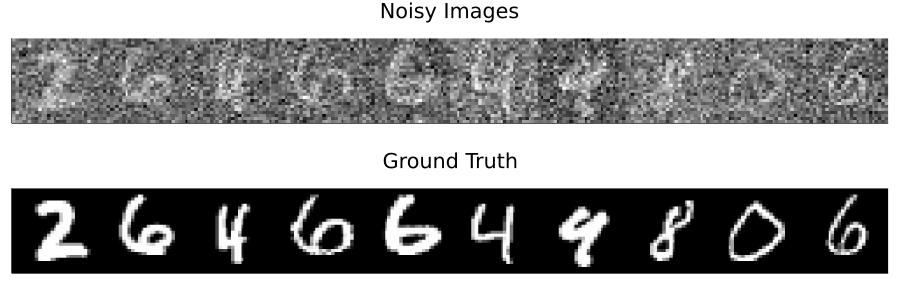

In [51]:
plot_reconstructed_images(noisy,clean,"Noisy Images","Ground Truth")

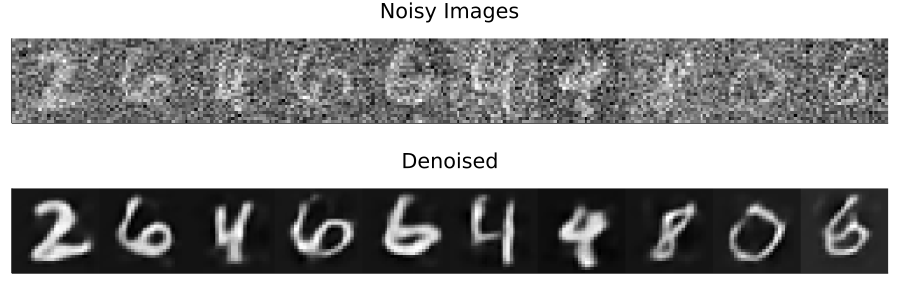

In [52]:
denoised = inference_forward_visual(w,noisy,clean,data_mean,data_std,1)
plot_reconstructed_images(noisy,denoised,"Noisy Images","Denoised")

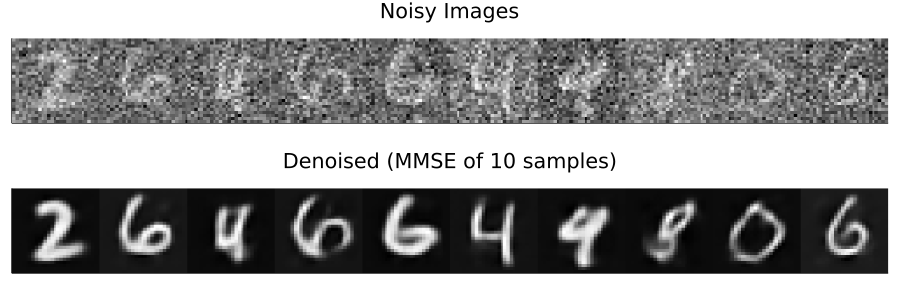

In [53]:
denoised = inference_forward_visual(w,noisy,clean,data_mean,data_std,10)
plot_reconstructed_images(noisy,denoised,"Noisy Images","Denoised (MMSE of 10 samples)")

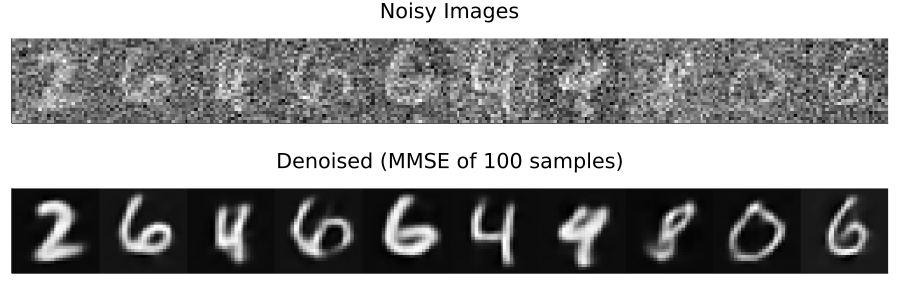

In [54]:
denoised = inference_forward_visual(w,noisy,clean,data_mean,data_std,100)
plot_reconstructed_images(noisy,denoised)
plot_reconstructed_images(noisy,denoised,"Noisy Images","Denoised (MMSE of 100 samples)")

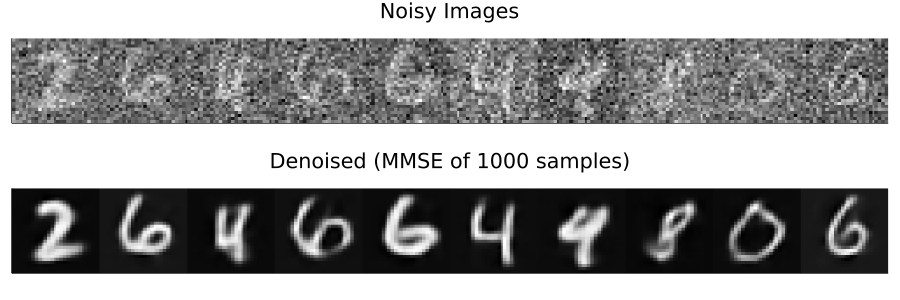

In [55]:
denoised = inference_forward_visual(w,noisy,clean,data_mean,data_std,1000)
plot_reconstructed_images(noisy,denoised)
plot_reconstructed_images(noisy,denoised,"Noisy Images","Denoised (MMSE of 1000 samples)")